# Generate GeM annotation

## 1. Import the necessary packages.

In [2]:
# Computer vision
import cv2
import mahotas
import numpy as np

# File handling
import codecs

# GeM generator
from generator import describe, detect_roi, generate_photo, generate_text, load_model, preprocess, project

# Jupyter notebook
from IPython.display import Image

## 2. Set up the classifier

Load the pre-trained data and labels.

In [3]:
model = load_model()

## 3. Prepare the document image.

Preprocess the document image.

In [4]:
image, original, filename, filepath = preprocess("test_images/2005-hwy-side_b-5_300dpi.jpg")

Detect regions of interest in the document image.

In [5]:
contours, hierarchy = detect_roi(image)

Examine the contours for false positives.

In [6]:
for n, c in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 1)
    cv2.imwrite("image_contours.png", image)

In [7]:
len(contours)

24

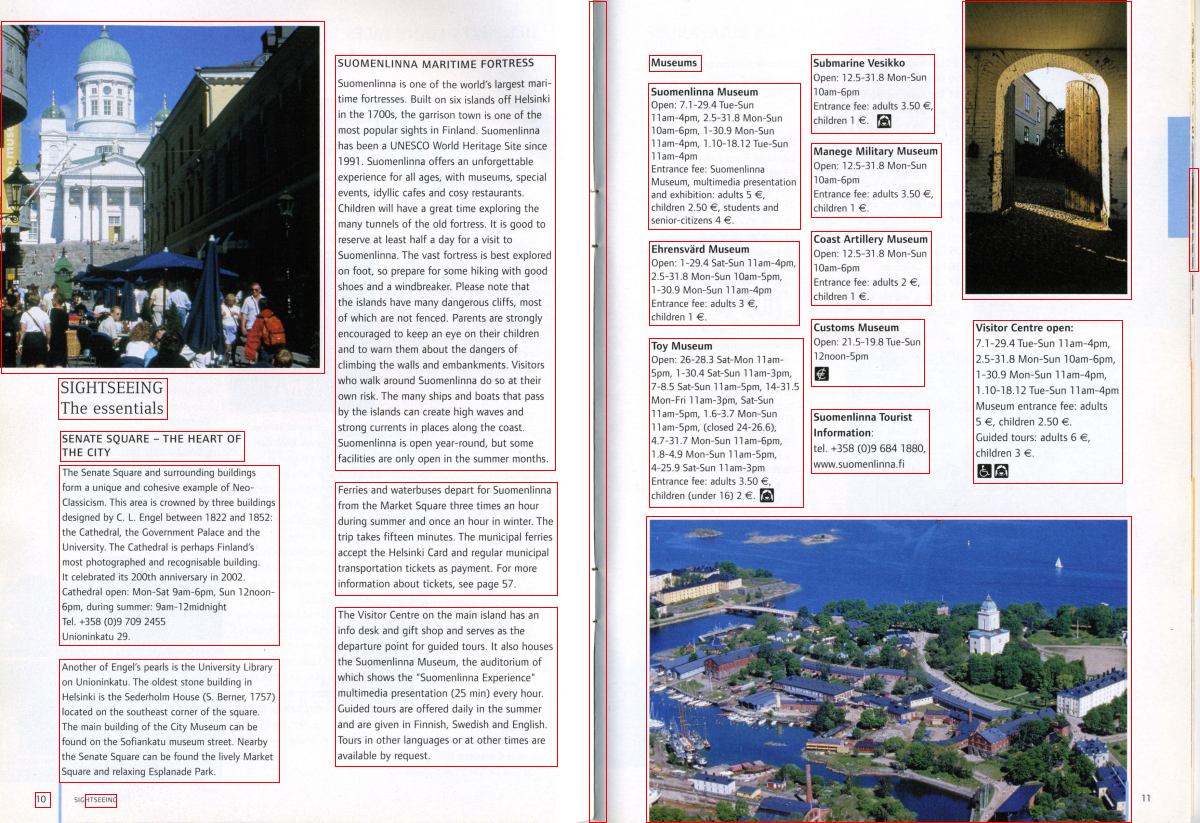

In [8]:
Image(filename="image_contours.png")

Project the detected contours on the original high resolution document image.

In [ ]:
contours = project(image, original, contours)

## 4. Begin the annotation.

Open the XML file.

In [ ]:
layout_file_name = str(filename) + '-layout-2.xml'
xmlfile = codecs.open(layout_file_name, 'w', 'utf-8')

xml_opening = '<?xml version="1.0" encoding="UTF-8"?>\n\n <gemLayout>\n'

Write preamble.

In [ ]:
xmlfile.write(xml_opening)

In [ ]:
oh = original.shape[0]
ow = original.shape[1]

segmentation = []
area_model = []
realization = []

for num, c in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(c)
    if h <= (0.9 * oh):
        bounding_box = original[y:y+h, x:x+w]
        features = describe(bounding_box)
        prediction = model.predict(features)[0]
        if prediction == 'text':
            # Draw rectange on original image
            cv2.rectangle(original, (x, y), (x + w, y + h), (0, 0, 255), 1)
            # Generate XML entries
            lu, sa, re = generate_text(original, x, w, y, h, num)
            # Append descriptions to list
            segmentation.append(lu)
            area_model.append(sa)
            realization.append(re)
        if prediction == 'photo':
            # Draw rectange on original image
            cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
            # Generate XML entries
            vlu, vsa, vre = generate_photo(original, x, w, y, h, num)
            # Append descriptions to list
            segmentation.append(vlu)
            area_model.append(vsa)
            realization.append(vre)

## 4. Generate the GeM XML file

Generate annotation for layout layer segmentation.

In [ ]:
segmentation_opening = '\t<segmentation>\n'

xmlfile.write("".join(segmentation_opening))

for s in segmentation:
    xmlfile.write("".join(s))
    
segmentation_closing = '\t</segmentation>\n'

xmlfile.write("".join(segmentation_closing))

Generate annotation for area model.

In [ ]:
areamodel_opening = '\t<area-model>\n'

xmlfile.write("".join(areamodel_opening))

for a in area_model:
    xmlfile.write("".join(a))
    
areamodel_closing = '\t</area-model>\n'

xmlfile.write("".join(areamodel_closing))

Generate annotation for realization information.

In [ ]:
realization_opening = '\t<realization>\n'

xmlfile.write("".join(realization_opening))

for r in realization:
    xmlfile.write("".join(r))
    
realization_closing = '\t</realization>\n'

xmlfile.write("".join(realization_closing))

Write closing tag.

In [ ]:
xmlfile_closing = '</gemLayout>'

xmlfile.write("".join(xmlfile_closing))

In [ ]:
xmlfile.close()